In [3]:
import sys
# 假设你要添加的路径是 '/path/to/your/module'
new_path = '~/go/code'

# 将新路径添加到sys.path列表的末尾
if new_path not in sys.path:
    sys.path.append(new_path)
print(sys.path)

['/home/jm/go/code', '/home/jm/.pyenv/versions/3.11.9/lib/python311.zip', '/home/jm/.pyenv/versions/3.11.9/lib/python3.11', '/home/jm/.pyenv/versions/3.11.9/lib/python3.11/lib-dynload', '', '/home/jm/.pyenv/versions/3.11.9/envs/dlgo311/lib/python3.11/site-packages', '~/go/code']


# 首先要找到并打开经验文件
## 看看那个最大的文件是不是
```
文件名是：alphago_rl_experience.h5
就是它了。600多M，github都嫌太大。
```

## 谁要打开这个文件
```
1、谁要训练，谁就要打开这个文件。
2、策略网络不仅需要生成这个文件，而且也需要这些文件进行强化训练。
3、(上面这句话错了，前半句不对，后半句也不对)
4、而强化训练，模型和策略网络一致的，只不过反复自己进化。
5、因此，文件名带rl的，即强化训练文件，既需要打开这个文件，也会生成这种文件。
```

### 实际文件考察
```
1、alphago_policy_sl.py，这个程序用来生成经过训练的alphago策略模型。
2、alphago_policy_rl.py，在alphago策略模型基础上，通过强化训练提高自己。会通过对弈生成经验文件。
3、alphago_value.py，是一个价值模型，也需要用到这个经验文件。
4、前面两个都是策略模型，文件名中带policy；后面是价值模型，文件名不带policy，但是带value
5、注意，value网络需要从0开始训练，并不能从人类棋谱的监督学习中受益！
6、另外，此处的value网络不能用来对弈，因为不是action-value网络。
7、如果想要对弈，就要开发适合value模型的代码。比如，把所有候选着法的价值都算一遍，取最大值。
```
### 实际训练过程再复述
```
1、先用人类棋谱训练policy网络
2、训练好的网络，在此基础上，继续进行强化训练。强化训练生成的训练数据，应该保存。
3、用保存的强化训练的数据，从0开始训练一个价值网络。
4、再加一个轻量级policy网络，alphago的三个网络就有了。
```

### 现存问题
```
1、现在价值网络不能下棋，本来就不行。
(这个又是认识错误，这个value已经实现了下棋，而且之前就是用这个方法实现了下棋，只是效果最差！)
2、但也导致对价值网络失去信心，因此需要验证
3、验证有两种。一种是确认经验数据还基本靠谱；一种是给价值网络一个下棋程序，看一下还行不行？
```

### 新发现问题
```
1、检查了experience文件，发现每个特征文件之间隔了两步。
2、之前的印象，留下的都是每一步都是有一个特征state的。
3、因为经验是两个agent分开存的，所以是这个样子！
4、就是原书的作者，更多地从工程方便角度编码，而略去了很多围棋相关的特征！
```

# 打开alphago_rl_experience.h5文件
## alphago_value.py有这个打开文件的方法load_experience

In [1]:
import h5py

from dlgo.rl import ValueAgent, load_experience
experience = load_experience(h5py.File('alphago_rl_experience.h5', 'r'))
# 前面顺利执行完毕

2024-05-04 08:52:19.299209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
n = experience.states.shape[0]
print(n) # 确定样例总数
print(type(experience.states))
transposed_arr = experience.states.transpose((0, 3, 1, 2))
print(experience.states.shape) # 确定形状
print(transposed_arr.shape) # 确定形状
print(experience.states[0].shape) # 确定形状
print(experience.states[257][:,:,0]) # 打印[19,19,0]
print(experience.states[257][:,:,1]) # 打印[19,19,1]
print(experience.states[257][:,:,2]) # 打印[19,19,2]
# (37323,19,19,49)是bhwc,和之前BCHW是不一样的，不过这个有现成方法改变。

print(dir(experience))
#print(vars(experience))
print(experience.actions.shape) # 确定形状,(37323,)
print(experience.actions[257])


37323
<class 'numpy.ndarray'>
(37323, 19, 19, 49)
(37323, 49, 19, 19)
(19, 19, 49)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 

In [ ]:
# from dlgo.data.parallel_processor import GoDataProcessor
# from dlgo.encoders.oneplane import OnePlaneEncoder
# from dlgo.networks import small,large
# from keras.models import Sequential
# from keras.layers.core import Dense
# from keras.callbacks import ModelCheckpoint

# go_board_rows, go_board_cols = 19, 19
# num_classes = go_board_rows * go_board_cols
# num_games = 100
# encoder = OnePlaneEncoder((go_board_rows, go_board_cols))
# processor = GoDataProcessor(encoder=encoder.name())
# generator = processor.load_go_data('train', num_games, use_generator=True)
# test_generator = processor.load_go_data('test', num_games, use_generator=True)


# input_shape = (encoder.num_planes, go_board_rows, go_board_cols)
# #network_layers = small.layers(input_shape)
# network_layers = large.layers(input_shape)
# model = Sequential()
# for layer in network_layers:
#     model.add(layer)
# model.add(Dense(num_classes, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])


# epochs = 5
# batch_size = 128
# model.fit_generator(
#     generator=generator.generate(batch_size, num_classes),
#     epochs=epochs,
#     steps_per_epoch=generator.get_num_samples() / batch_size,
#     validation_data=test_generator.generate(batch_size, num_classes),
#     validation_steps=test_generator.get_num_samples() / batch_size,
#     # 下面这句..改为.，就是写到当前目录中去，可能会覆盖，反正也不提交。
#     callbacks=[ModelCheckpoint('./checkpoints/large_model_epoch_{epoch}.h5')]
# )
# model.evaluate_generator(
#     generator=test_generator.generate(batch_size, num_classes),
#     steps=test_generator.get_num_samples() / batch_size
# )

In [33]:
import numpy as np


# 替换为你的.npy文件的实际路径
file_path = '/home/jm/go/code/data/KGS-2004-19-12106-train_features_0.npy'
# 加载.npy文件中的数据
array_data = np.load(file_path)

array_data_f = array_data


file_path = '/home/jm/go/code/data/KGS-2004-19-12106-train_labels_0.npy'
array_data_l = np.load(file_path)

array_data_f = transposed_arr
array_data_l = experience.actions

# 现在array_data是一个NumPy数组，你可以进行各种操作
print(array_data_f.shape)
print(array_data_l.shape)
print(array_data_l.argmax())
print(array_data_l[50])

a = array_data_l[100]
print(a%19)
print(a//19)

(37323, 49, 19, 19)
(37323,)
134
157
6
12


In [34]:
print(array_data.shape)
i=8
print(array_data[100,6+i])
print(array_data[100,7+i])
print(array_data[100,8+i])
print(array_data[100,9+i])
print(array_data[100,10+i])
print(array_data[100,11+i])
print(array_data[100,12+i])
print(array_data[100,13+i])

(1024, 49, 19, 19)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

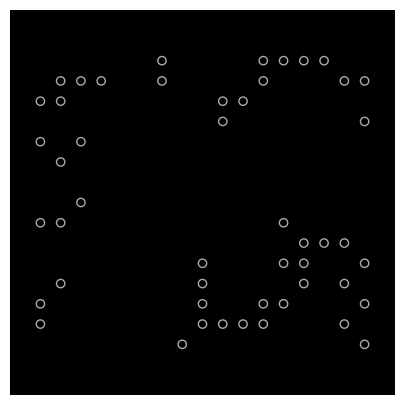

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有了上述的array_data，它是一个形状为 (1024, 1, 19, 19) 的数组
# 我们假设这是一系列19x19的棋盘状态，我们将抽取其中一个状态展示

# 抽取单个棋盘状态（例如索引为0的状态）
single_board = array_data[100, 0]

# 将棋盘数据转换为黑白棋子的形式，比如-1可能代表黑子，1可能代表白子，0代表空位
# （这里假设正负值代表不同的棋子，具体可以根据实际情况调整）
black_stones = single_board == -1
white_stones = single_board == 1

# 设置棋盘边框颜色
edge_color = "#aaaaaa"

fig, ax = plt.subplots(figsize=(5, 5))

# 绘制棋盘背景
ax.imshow(np.zeros_like(single_board), cmap="gray", interpolation="none")

# 绘制黑子
ax.scatter(*np.where(black_stones), color='black', marker='o')

# 绘制白子
ax.scatter(*np.where(white_stones), color='white', edgecolors=edge_color, facecolors='none', marker='o')

# 移除坐标轴
ax.axis('off')

plt.show()

预测数是17, 列是0, 行是2


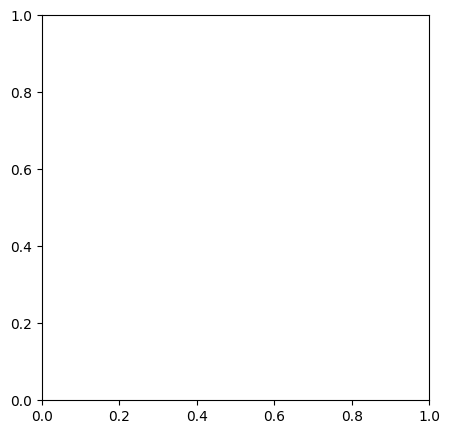

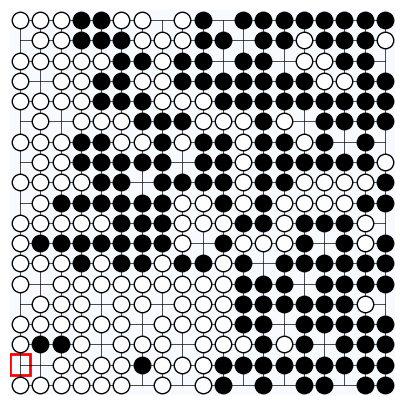

预测数是35, 列是1, 行是3


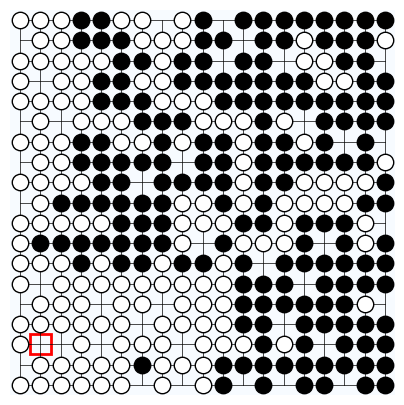

预测数是190, 列是10, 行是19


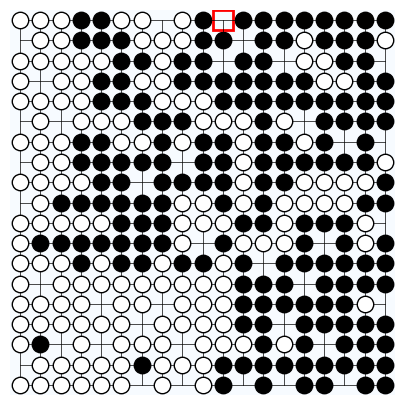

预测数是356, 列是18, 行是5


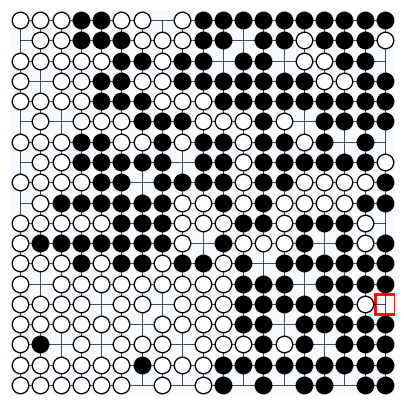

预测数是344, 列是18, 行是17


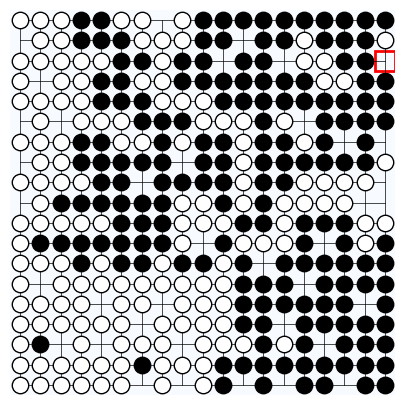

预测数是182, 列是9, 行是8


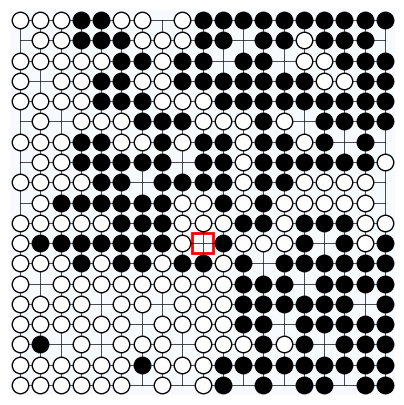

预测数是163, 列是8, 行是8


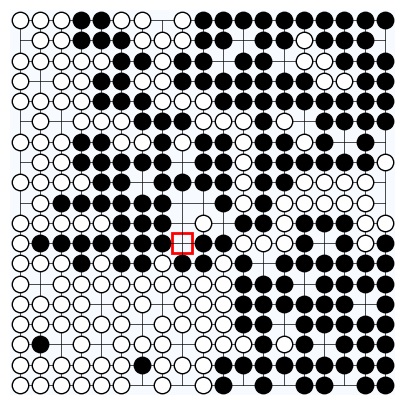

预测数是161, 列是8, 行是10


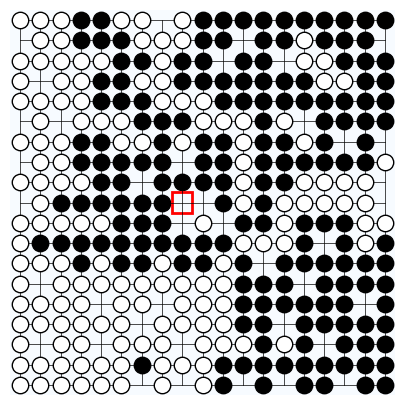

预测数是162, 列是8, 行是9


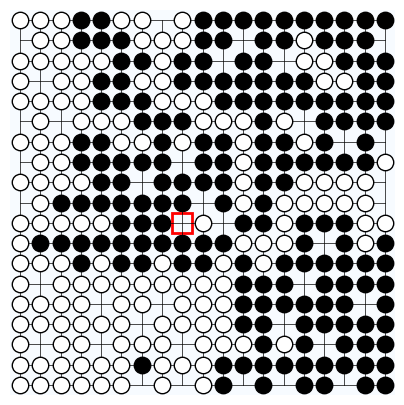

预测数是351, 列是18, 行是10


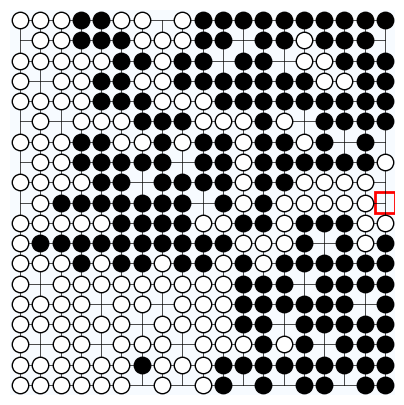

预测数是249, 列是13, 行是17


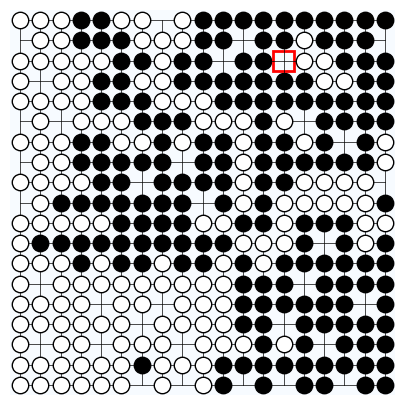

预测数是262, 列是13, 行是4


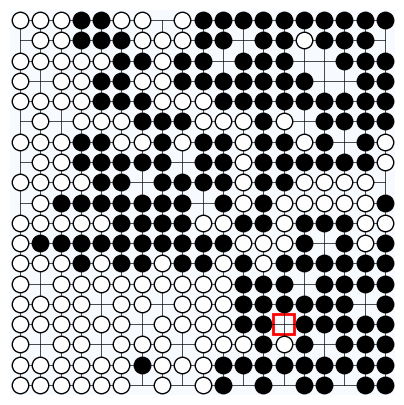

预测数是180, 列是9, 行是10


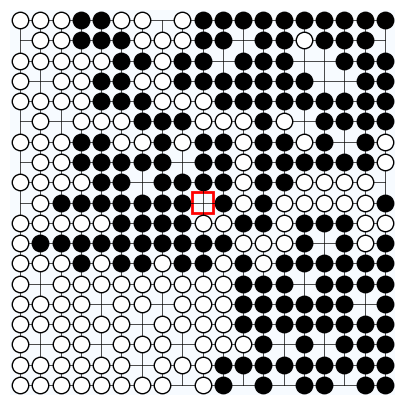

预测数是307, 列是16, 行是16


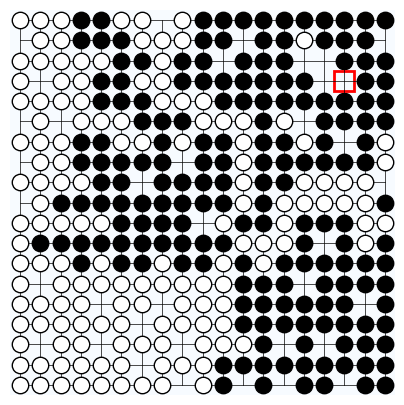

预测数是159, 列是8, 行是12


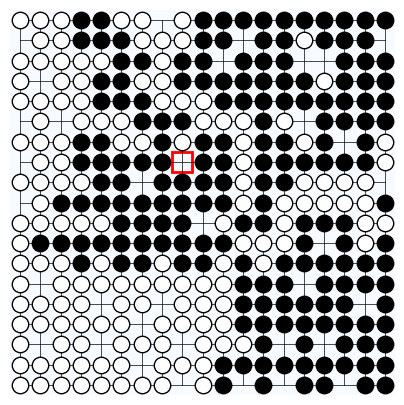

预测数是133, 列是7, 行是19


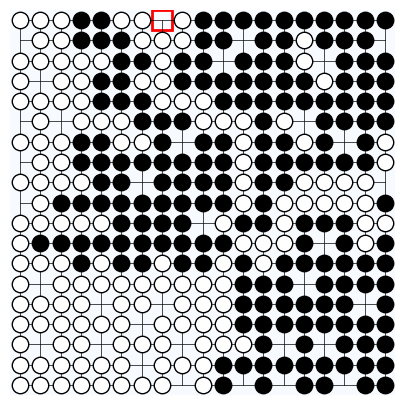

预测数是153, 列是8, 行是18


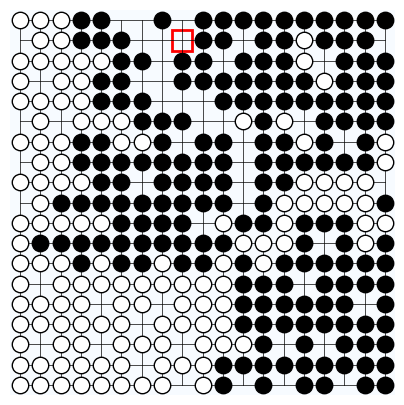

预测数是271, 列是14, 行是14


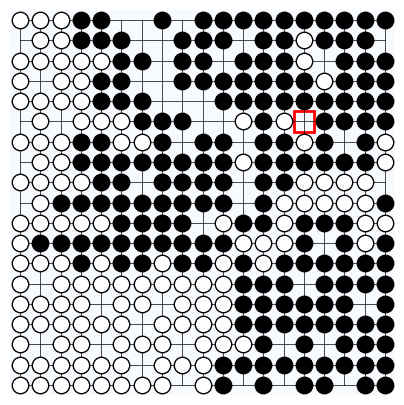

预测数是181, 列是9, 行是9


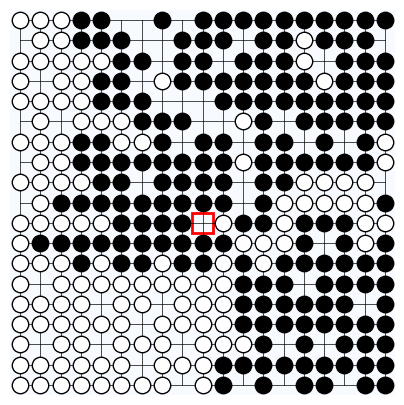

预测数是287, 列是15, 行是17


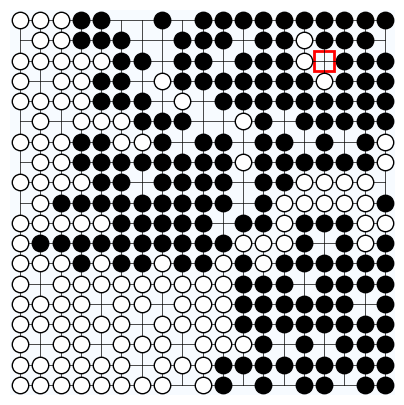

预测数是267, 列是14, 行是18


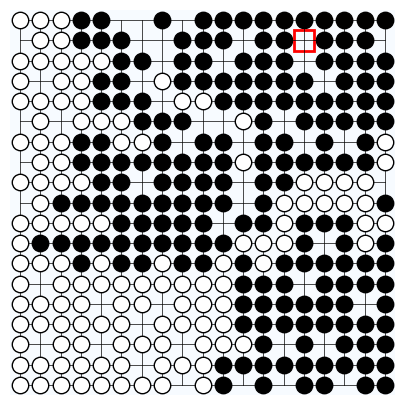

预测数是137, 列是7, 行是15


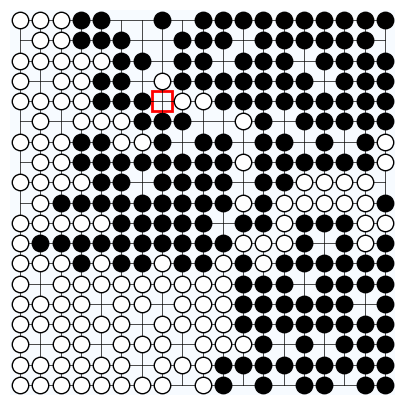

预测数是217, 列是11, 行是11


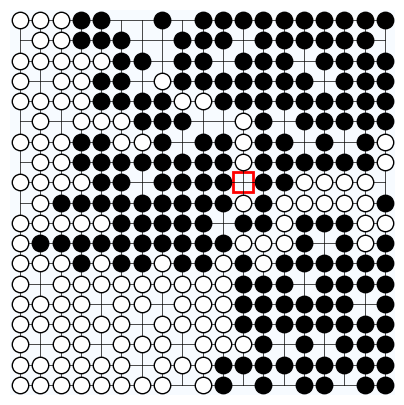

预测数是117, 列是6, 行是16


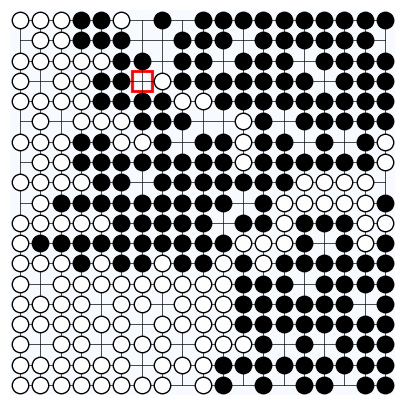

预测数是134, 列是7, 行是18


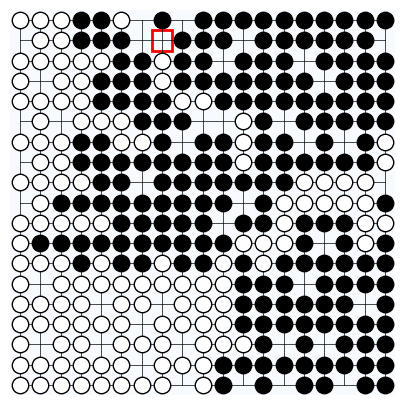

预测数是350, 列是18, 行是11


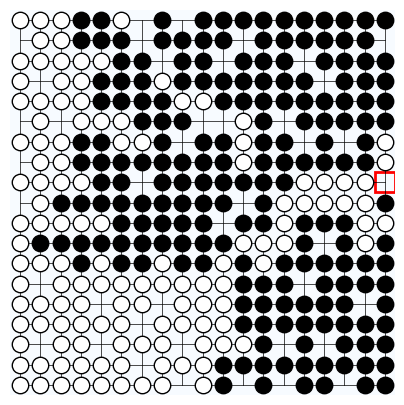

预测数是294, 列是15, 行是10


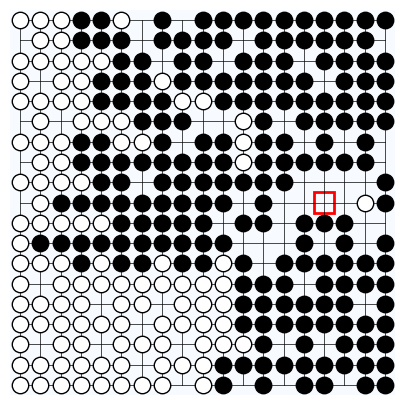

预测数是239, 列是12, 行是8


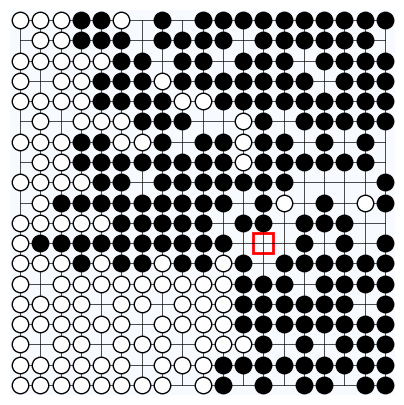

预测数是135, 列是7, 行是17


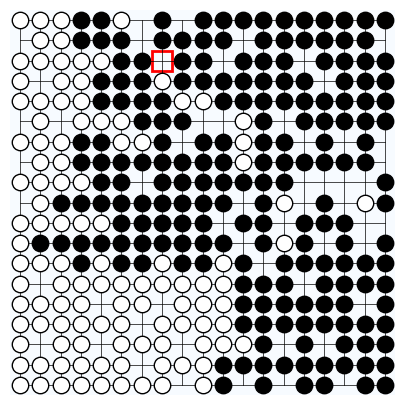

预测数是348, 列是18, 行是13


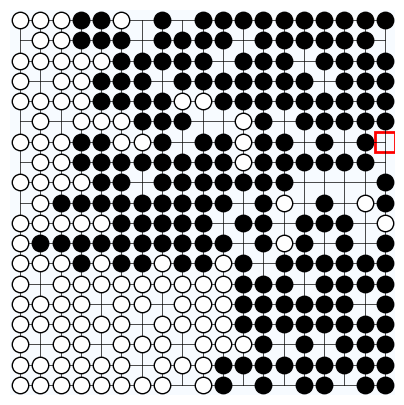

预测数是220, 列是11, 行是8


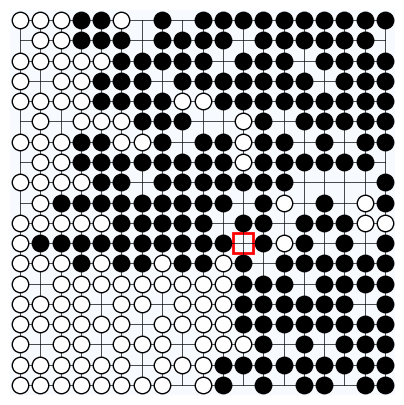

预测数是312, 列是16, 行是11


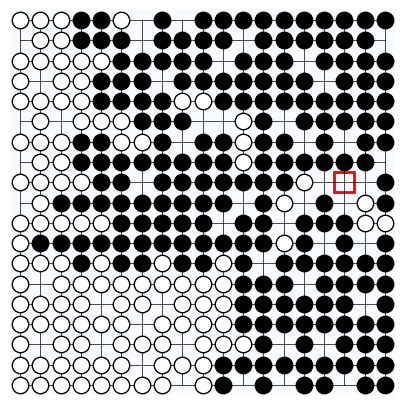

KeyboardInterrupt: 

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有了上述的array_data，它是一个形状为 (1024, 1, 19, 19) 的数组
# 我们假设这是一系列19x19的棋盘状态，我们将抽取其中一个状态展示

# 抽取单个棋盘状态（例如索引为0的状态）

# 假设您已经有了一维索引变量 `current_step`，并且初始值为0
current_step = 210

# 创建一个新的figure，或者清理现有figure中的所有元素
if plt.get_fignums():
    fig, ax = plt.gcf(), plt.gca()  # 获取当前figure和axis
    ax.cla()  # 清理当前axis上的所有内容
else:
    fig, ax = plt.subplots(figsize=(5, 5))    

#ax.invert_yaxis()

while current_step < array_data_f.shape[0]:

    # 计算预测点的坐标
    #x, y = divmod(predict_stone, 19)  # 商为列，余数为行
    #x, y = x + 1, y + 1  # 棋盘坐标从1开始计数
    #x = predict_stone // 19 + 1
    #y = predict_stone % 19  + 1
    #print(f"预测数是{predict_stone},商是{x},余数是{y}")
    
    # 计算预测点的坐标
    predict_stone = array_data_l[current_step]
    x = predict_stone // 19  # 转换为棋盘上的列坐标
    y = 19 - (predict_stone % 19)  # 转换为棋盘上的行坐标（从底部开始计数）

    print(f"预测数是{predict_stone}, 列是{x}, 行是{y}")    
    
    # 将棋盘数据转换为黑白棋子的形式，比如-1可能代表黑子，1可能代表白子，0代表空位
    # （这里假设正负值代表不同的棋子，具体可以根据实际情况调整）
    single_board0 = array_data_f[current_step, 0]
    single_board1 = array_data_f[current_step, 1]
    black_stones = single_board0 == 1
    white_stones = single_board1 == 1

    # 设置棋盘边框颜色
    edge_color = "#000000"  # 黑色

    fig, ax = plt.subplots(figsize=(5, 5))

    # 绘制黄色棋盘背景
    ax.imshow(np.ones_like(single_board), cmap="Blues", interpolation="none")  # 将这里改为Yellow

    # 绘制棋盘线条
    for i in range(19):
        ax.plot(np.arange(19), [i] * 19, color=edge_color, linewidth=0.5)  # 横线
        ax.plot([i] * 19, np.arange(19), color=edge_color, linewidth=0.5)  # 纵线

    # 绘制黑子
    ax.scatter(*np.where(black_stones), color='black', marker='o',s=140)

    # 绘制白子
    ax.scatter(*np.where(white_stones), color='white',  edgecolors=edge_color, facecolors='white', marker='o', s=140,zorder=2)



    # 绘制红色正方形
    #rect = plt.Rectangle((y - 0.5, x - 0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
    rect = plt.Rectangle((x - 0.5, 18.5 - y ), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    
    # 移除坐标轴
    ax.axis('off')

    plt.draw()
    plt.pause(5)  # 暂停5秒
    # 进入下一手
    current_step += 1